# Convert SnowMIP forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Sodankylä, Finland

Small clearing in a pine plantation with sandy loam soil. Wind speed and radiation are
measured above the canopy height, so forcing data have been adjusted for sheltering of
the clearing.

| Short name | sod |
|:-----------|:----|
| Location | 67.37ºN, 26.63ºE |
| Elevation | 179 m |
| Snow-free albedo | - |
| Simulation period | 1 October 2007 to 30 September 2014 |
| Temperature/humidity measurement height | 2 m |
| Wind measurement height | 2 m |
| Reference | Essery et al. ([2016](https://gi.copernicus.org/articles/5/219/2016/)) |

In [2]:
site = 'sod'
site_longname = 'Sodankylä, Finland'

year_start = '2007'
year_end = '2014'

lat = 67.368 
lon = 26.633

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/sod already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/sod/forcing already exist.


### Open original forcing file

In [3]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 61368)
Coordinates:
  * time     (time) datetime64[ns] 2007-10-01T01:00:00 ... 2014-10-01
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

In [4]:
ds.time.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1048576,),
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/met_insitu_sod_2007_2014.nc',
 'original_shape': (61368,),
 'dtype': dtype('float32'),
 'units': 'hours since 1900-01-01 00:00:00.0'}

In [5]:
# Check if there are leap years
# ds.sel(time='2004-02')
# ds.sel(time='2008-02')
ds.sel(time='2012-02')
# ds.sel(time='2016-02')

<xarray.Dataset>
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-02-29T23:00:00
Data variables:
    LWdown   (time) float32 ...
    Psurf    (time) float32 ...
    Qair     (time) float32 ...
    Rainf    (time) float32 ...
    Snowf    (time) float32 ...
    SWdown   (time) float32 ...
    Tair     (time) float32 ...
    Wind     (time) float32 ...

### Resample to 30 minute time step for CLASSIC
Otherwise CLASSIC interpolates the forcing by itself and makes some assumptions more adapted for 6h forcing files
(e.g., for the SWdown that will lose the peaks)

In [6]:
ds_30min = ds.resample(time='30min').interpolate()
ds_30min

<xarray.Dataset>
Dimensions:  (time: 122735)
Coordinates:
  * time     (time) datetime64[ns] 2007-10-01T01:00:00 ... 2014-10-01
Data variables:
    LWdown   (time) float64 357.1 356.7 356.2 356.2 ... 241.9 242.0 240.8 239.7
    Psurf    (time) float64 1.002e+05 1.002e+05 ... 1.007e+05 1.007e+05
    Qair     (time) float64 0.00627 0.00644 0.00661 ... 0.002661 0.002601
    Rainf    (time) float64 0.0 8.35e-05 0.000167 0.000514 ... 0.0 0.0 0.0 0.0
    Snowf    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    SWdown   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Tair     (time) float64 282.5 282.1 281.8 281.8 ... 269.6 269.4 269.1 268.8
    Wind     (time) float64 0.9 0.85 0.8 0.75 0.7 0.65 ... 0.1 0.15 0.2 0.25 0.3

## Check that after interpolation the cumulated precip (in mm/year) is reasonably conserved

In [7]:
ds.Snowf.sum()*3600*24/365

<xarray.DataArray 'Snowf' ()>
array(102.23352093)

In [8]:
ds_30min.Snowf.sum()*3600*24/365/2

<xarray.DataArray 'Snowf' ()>
array(102.23352142)

In [9]:
ds.Rainf.sum()*3600*24/365

<xarray.DataArray 'Rainf' ()>
array(157.58041748)

In [10]:
ds_30min.Rainf.sum()*3600*24/365/2

<xarray.DataArray 'Rainf' ()>
array(157.58041618)

### Extend beginning and the end of the forcing
Because CLASSIC only accept full years (will need to be removed for analyses)

In [11]:
time_ext = pd.date_range(
    pd.to_datetime(ds_30min.time.dt.year[0], format='%Y'), 
    str(ds_30min.time.dt.year[-1].values.item(0))+'-12-31 23:30:00',
    freq='30min'
)
time_ext

DatetimeIndex(['2007-01-01 00:00:00', '2007-01-01 00:30:00',
               '2007-01-01 01:00:00', '2007-01-01 01:30:00',
               '2007-01-01 02:00:00', '2007-01-01 02:30:00',
               '2007-01-01 03:00:00', '2007-01-01 03:30:00',
               '2007-01-01 04:00:00', '2007-01-01 04:30:00',
               ...
               '2014-12-31 19:00:00', '2014-12-31 19:30:00',
               '2014-12-31 20:00:00', '2014-12-31 20:30:00',
               '2014-12-31 21:00:00', '2014-12-31 21:30:00',
               '2014-12-31 22:00:00', '2014-12-31 22:30:00',
               '2014-12-31 23:00:00', '2014-12-31 23:30:00'],
              dtype='datetime64[ns]', length=140256, freq='30T')

In [12]:
ds_30min_ext = ds_30min.reindex(time=time_ext)
ds_30min_ext

<xarray.Dataset>
Dimensions:  (time: 140256)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 ... 2014-12-31T23:30:00
Data variables:
    LWdown   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Psurf    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Qair     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rainf    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Snowf    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    SWdown   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Tair     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Wind     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [13]:
# ds_30min    : XXXXXXXXXXXXXXXXXXXXXXXXXXXX........... i_start_next_year ....... i_end_next_year
# ds_30min_ext: 1rst jan .... i_before_start

i_before_start = ds_30min_ext.sel(time=slice(None,ds_30min.time[0])).time.size - 1 
i_start_next_year = ds_30min.sel(time=slice(None, year_start)).time.size
i_end_next_year = i_start_next_year + i_before_start

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][:i_before_start].size,
    ds_30min['Wind'][i_start_next_year:i_end_next_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][:i_before_start] = ds_30min[key][i_start_next_year:i_end_next_year].values

In [14]:
# ds_30min    : i_start_prev_year ....... i_end_prev_year.......XXXXXXXXXXXXXXXXXXXXXXXXXXXX
# ds_30min_ext: ............................................... i_after_end.......... 31 dec

i_after_end = ds_30min_ext.sel(time=slice(ds_30min.time[-1]+1, None)).time.size
i_end_prev_year = ds_30min.time.sel(time=slice(year_end, None)).time.size
i_start_prev_year = i_end_prev_year + i_after_end

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][-i_after_end:].size,
    ds_30min['Wind'][-i_start_prev_year:-i_end_prev_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][-i_after_end:] = ds_30min[key][-i_start_prev_year:-i_end_prev_year].values

Text(0.5, 0.98, 'Sodankylä, Finland')

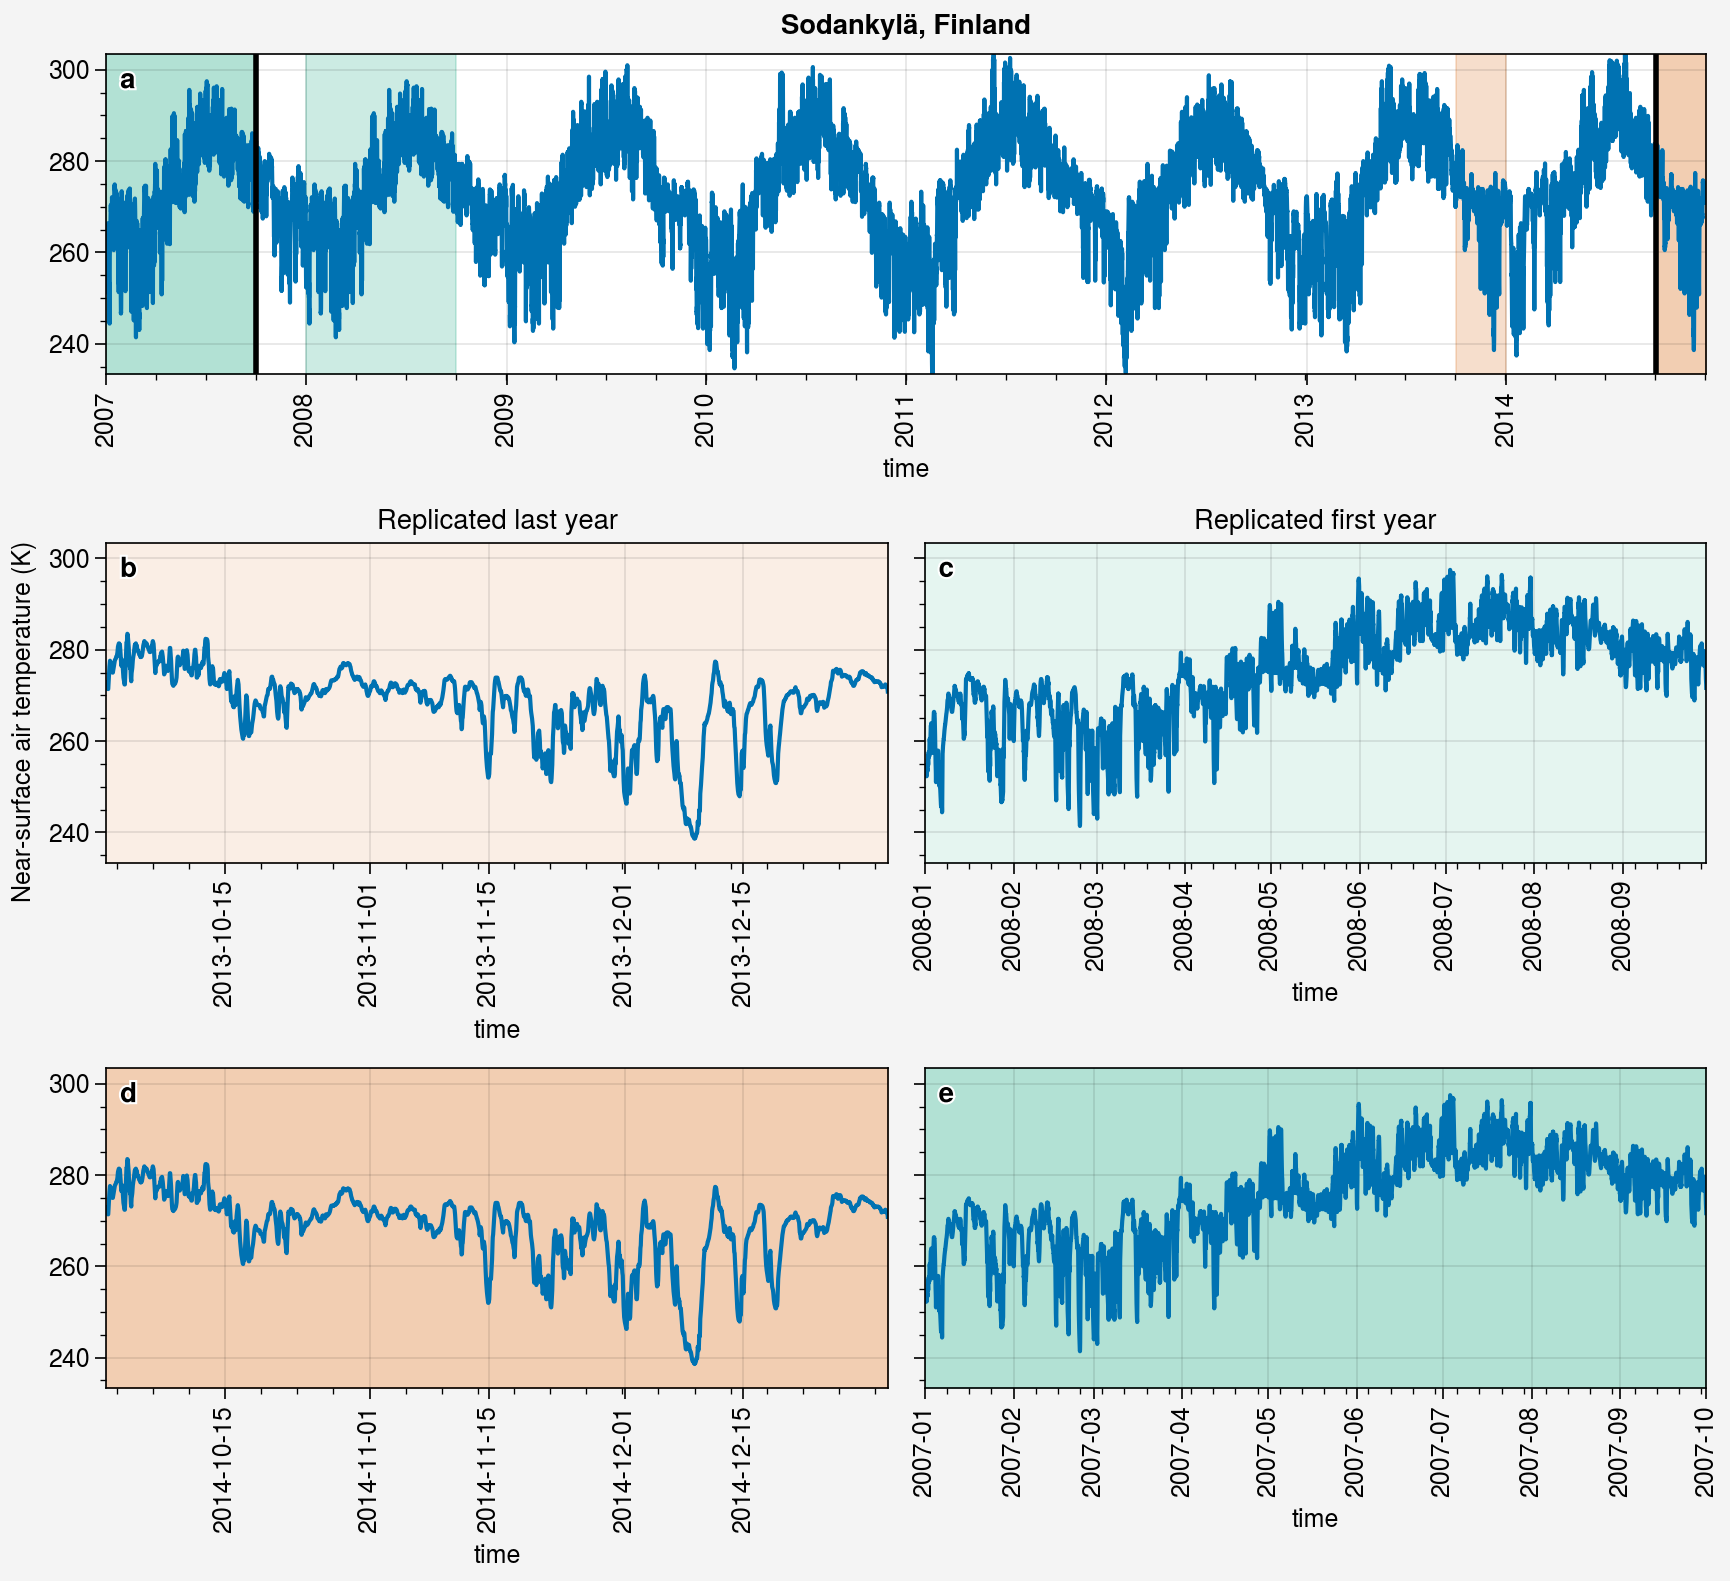

In [15]:
%matplotlib inline
fig, axs = pplt.subplots([[1, 1], [2, 3], [4, 5]], refaspect=5, refwidth=8, sharex=0)

key = 'Tair'

axs[0].plot(ds_30min_ext[key])

axs[0].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.2
)

axs[0].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.2
)

axs[0].axvline(ds_30min[key][0].time.values, lw=2, ls='-', color='k')
axs[0].axvline(ds_30min[key][-1].time.values, lw=2, ls='-', color='k')

axs[2].format(title='Replicated first year')
axs[4].plot(ds_30min_ext[key][:i_before_start])
axs[4].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)
axs[2].plot(ds_30min[key][i_start_next_year:i_end_next_year])
axs[2].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[1].format(title='Replicated last year')
axs[3].plot(ds_30min_ext[key][-i_after_end:])
axs[3].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)
axs[1].plot(ds_30min[key][-i_start_prev_year:-i_end_prev_year])
axs[1].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs.format(abc=True, abcloc='ul')
fig.suptitle(site_longname)


### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [16]:
ds_30min_ext.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'.nc')

In [17]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}.nc {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 1122048 values from 8 variables over 140256 timesteps [19.39s 392MB]


## Open the new file with absolute time

In [18]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_a.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 140256)
Coordinates:
  * time     (time) float64 2.007e+07 2.007e+07 ... 2.014e+07 2.014e+07
Data variables:
    LWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Qair     (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...
    SWdown   (time) float64 ...
    Tair     (time) float64 ...
    Wind     (time) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 20 11:08:18 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [19]:
ds.time

<xarray.DataArray 'time' (time: 140256)>
array([20070101.      , 20070101.020833, 20070101.041667, ..., 20141231.9375  ,
       20141231.958333, 20141231.979167])
Coordinates:
  * time     (time) float64 2.007e+07 2.007e+07 ... 2.014e+07 2.014e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [20]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset>
Dimensions:  (time: 140256, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 2.007e+07 2.007e+07 ... 2.014e+07 2.014e+07
  * lon      (lon) float64 26.63
  * lat      (lat) float64 67.37
Data variables:
    LWdown   (time, lat, lon) float64 213.5 217.2 221.0 ... 302.5 300.3 297.8
    Psurf    (time, lat, lon) float64 1.021e+05 1.021e+05 ... 9.88e+04 9.882e+04
    Qair     (time, lat, lon) float64 0.0006314 0.0006685 ... 0.003186 0.00305
    Rainf    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float64 0.0 0.0 0.0 ... 6.07e-05 3.04e-05 3.04e-05
    SWdown   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair     (time, lat, lon) float64 253.5 253.8 254.1 ... 271.5 271.3 270.8
    Wind     (time, lat, lon) float64 0.3 0.15 0.0 0.0 0.0 ... 0.5 0.9 1.3 1.4
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 20 11:08:18 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

### Convert temperature to °C (<mark>required by CLASSIC</mark>)

In [21]:
with xr.set_options(keep_attrs=True):
    ds['Tair'] = ds['Tair'] - 273.15
    ds.Tair.attrs['units'] = '°C'
ds.Tair

<xarray.DataArray 'Tair' (time: 140256, lat: 1, lon: 1)>
array([[[-19.65      ]],

       [[-19.34999695]],

       [[-19.0499939 ]],

       ...,

       [[ -1.60001221]],

       [[ -1.85001221]],

       [[ -2.30000916]]])
Coordinates:
  * time     (time) float64 2.007e+07 2.007e+07 ... 2.014e+07 2.014e+07
  * lon      (lon) float64 26.63
  * lat      (lat) float64 67.37
Attributes:
    long_name:  Near-surface air temperature
    units:      °C
    ALMA_name:  Tair
    CMIP_name:  ta

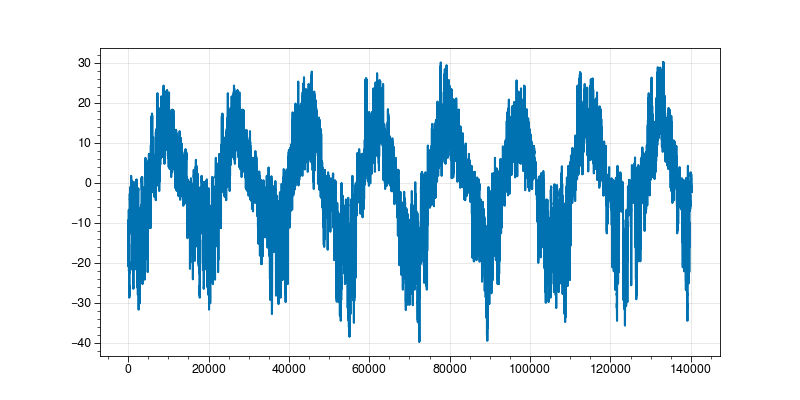

In [22]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

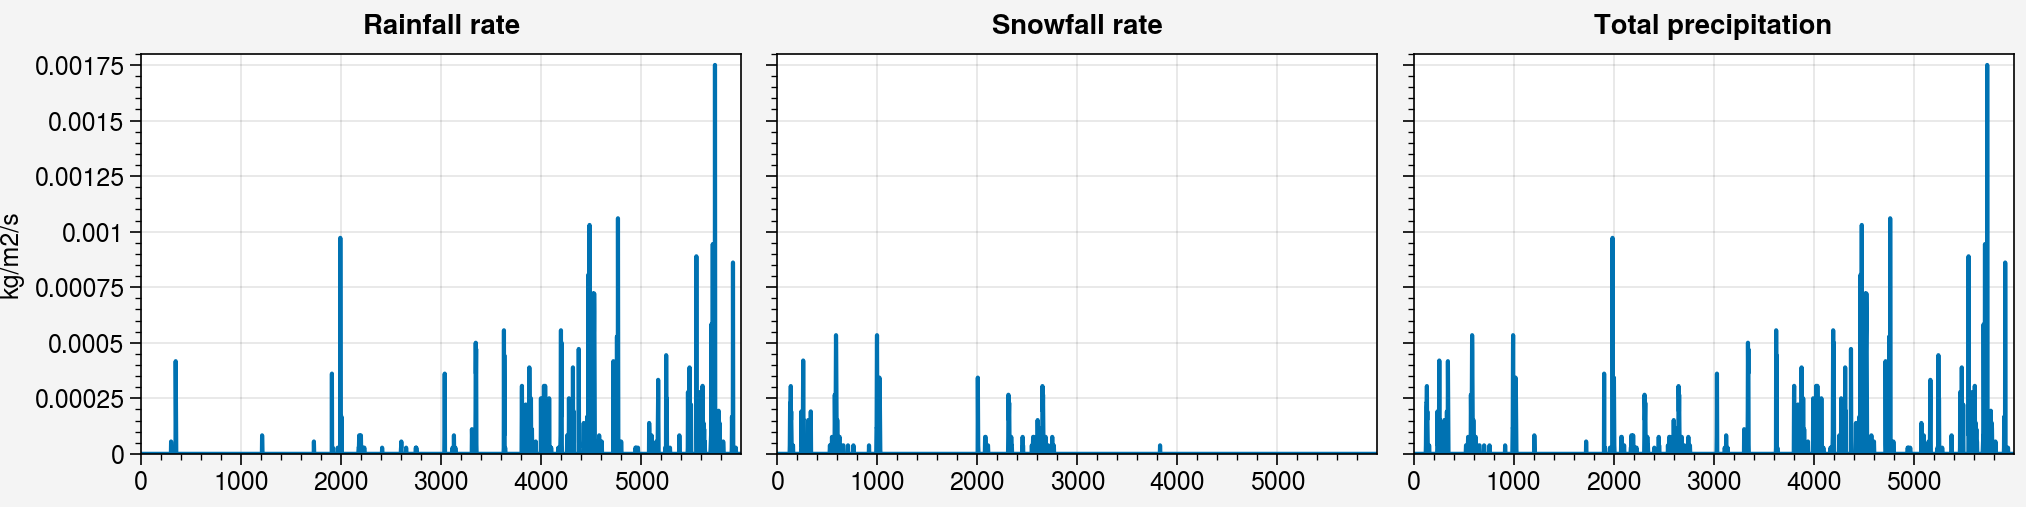

In [23]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 2000*2
i_end = 5000*2

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [24]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset>
Dimensions:    (time: 140256, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 2.007e+07 2.007e+07 ... 2.014e+07 2.014e+07
  * lon        (lon) float64 26.63
  * lat        (lat) float64 67.37
Data variables:
    LWdown     (time, lat, lon) float64 213.5 217.2 221.0 ... 302.5 300.3 297.8
    Psurf      (time, lat, lon) float64 1.021e+05 1.021e+05 ... 9.882e+04
    Qair       (time, lat, lon) float64 0.0006314 0.0006685 ... 0.003186 0.00305
    Rainf      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float64 0.0 0.0 0.0 ... 3.04e-05 3.04e-05
    SWdown     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair       (time, lat, lon) float64 -19.65 -19.35 -19.05 ... -1.6 -1.85 -2.3
    Wind       (time, lat, lon) float64 0.3 0.15 0.0 0.0 0.0 ... 0.5 0.9 1.3 1.4
    TotPrecip  (time, lat, lon) float64 0.0 0.0 0.0 ... 3.04e-05 3.04e-05
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 20 11:08:18 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## All the procedure may introduce negative precip values due to computing precision so replace them by 0

In [25]:
ds.Snowf.where(ds.Snowf < 0).sum()

<xarray.DataArray 'Snowf' ()>
array(-1.94478765e-18)

In [26]:
ds.Rainf.where(ds.Rainf < 0).sum()

<xarray.DataArray 'Rainf' ()>
array(-5.40745834e-18)

In [27]:
ds.TotPrecip.where(ds.TotPrecip < 0).sum()

<xarray.DataArray 'TotPrecip' ()>
array(-7.172675e-18)

In [28]:
ds['Rainf'] = ds.Rainf.where(ds.Rainf > 0, other=0)
ds['Snowf'] = ds.Snowf.where(ds.Snowf > 0, other=0)
ds['TotPrecip'] = ds.TotPrecip.where(ds.TotPrecip > 0, other=0)

In [29]:
np.testing.assert_equal(ds.Rainf.where(ds.Rainf < 0).sum().values, 0)
np.testing.assert_equal(ds.Snowf.where(ds.Snowf < 0).sum().values, 0)
np.testing.assert_equal(ds.TotPrecip.where(ds.TotPrecip < 0).sum().values, 0)

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [30]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')

In [31]:
!ls {path_out}

met_insitu_sod_2008_2013_LWdown.nc
met_insitu_sod_2008_2013_Psurf.nc
met_insitu_sod_2008_2013_Qair.nc
met_insitu_sod_2008_2013_Rainf.nc
met_insitu_sod_2008_2013_Snowf.nc
met_insitu_sod_2008_2013_SWdown.nc
met_insitu_sod_2008_2013_Tair.nc
met_insitu_sod_2008_2013_TotPrecip.nc
met_insitu_sod_2008_2013_Wind.nc
met_insitu_sod_30min_ext_2007_2014_LWdown.nc
met_insitu_sod_30min_ext_2007_2014_Psurf.nc
met_insitu_sod_30min_ext_2007_2014_Qair.nc
met_insitu_sod_30min_ext_2007_2014_Rainf.nc
met_insitu_sod_30min_ext_2007_2014_Snowf.nc
met_insitu_sod_30min_ext_2007_2014_SWdown.nc
met_insitu_sod_30min_ext_2007_2014_Tair.nc
met_insitu_sod_30min_ext_2007_2014_TotPrecip.nc
met_insitu_sod_30min_ext_2007_2014_Wind.nc


In [32]:
!ls {path_out_CLASSIC}

met_insitu_sod_2008_2013_LWdown.nc
met_insitu_sod_2008_2013_Psurf.nc
met_insitu_sod_2008_2013_Qair.nc
met_insitu_sod_2008_2013_Rainf.nc
met_insitu_sod_2008_2013_Snowf.nc
met_insitu_sod_2008_2013_SWdown.nc
met_insitu_sod_2008_2013_Tair.nc
met_insitu_sod_2008_2013_TotPrecip.nc
met_insitu_sod_2008_2013_Wind.nc
met_insitu_sod_30min_ext_2007_2014_LWdown.nc
met_insitu_sod_30min_ext_2007_2014_Psurf.nc
met_insitu_sod_30min_ext_2007_2014_Qair.nc
met_insitu_sod_30min_ext_2007_2014_Rainf.nc
met_insitu_sod_30min_ext_2007_2014_Snowf.nc
met_insitu_sod_30min_ext_2007_2014_SWdown.nc
met_insitu_sod_30min_ext_2007_2014_Tair.nc
met_insitu_sod_30min_ext_2007_2014_TotPrecip.nc
met_insitu_sod_30min_ext_2007_2014_Wind.nc


### Keep the same initial files from Ref run (but redo spinup)

In [33]:
path_init = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site
exp = 'Ref'
exp2 = 'Ref_30min_ext'
!cp {path_init}/{site}_init_spinup_{exp}.nc {path_init}/{site}_init_spinup_{exp2}.nc
!cp {path_init}/rsfile_spinup_{exp}.nc {path_init}/rsfile_spinup_{exp2}.nc

In [34]:
!mkdir /home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/{site}/spinup_{exp2}